<a href="https://colab.research.google.com/github/WannaBees/Python-Django-ecommerce-app/blob/master/DN_ZeroShotTM-ParametersOptimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ZeroShot TM

###**Overview** 

We use the cleaned Comments and Post Data from the DataScience Data Set of Stack Overflow to run the ZeroShot Topic Model.

ZeroShotTM is a topic model for tasks in which you might have missing words in the test data and also, if trained with muliglingual embeddings, it inherits the property of being a multilingual topic model.

Medium Blog Post: https://towardsdatascience.com/contextualized-topic-modeling-with-python-eacl2021-eacf6dfa576

Github Repository: https://github.com/MilaNLProc/contextualized-topic-models

### **Load** **Data**

In [ ]:
%%capture
!pip install contextualized-topic-models
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -U tqdm
!pip install pyldavis

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount =True)

Mounted at /content/drive


In [ ]:
!ls

drive  sample_data


In [ ]:
!cd drive/MyDrive/OffensiveML

In [ ]:
## load data 
posts_comments = 'drive/MyDrive/OffensiveML/posts_comments.txt'
documents = [line.strip() for line in open(posts_comments, encoding="utf-8").readlines()]

 ### **Preprocessing** **of** **data**

In [ ]:
from contextualized_topic_models.utils.preprocessing import WhiteSpacePreprocessingStopwords
from contextualized_topic_models.utils.data_preparation import TopicModelDataPreparation
from contextualized_topic_models.models.ctm import ZeroShotTM

import nltk 
from nltk.corpus import stopwords

nltk.download('stopwords') # stopwords to be removed from the data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

We need preprocessed text to get text without punctuation for the bag of words model. Ideally, we also have the most frequent words in our bag of words model.

In [ ]:
stopwords_english = set(stopwords.words('english'))
print(stopwords_english)

{'myself', 'not', "mustn't", 'all', 'if', 'down', 'ourselves', "you'd", 'y', 'did', 'over', "haven't", "should've", 'their', 'when', 'aren', 'once', 'can', 'above', "shouldn't", 'himself', 'd', 'so', 'or', 'has', "weren't", 'doing', 'now', 'our', 'before', "didn't", 'against', "hasn't", 'am', 'theirs', 'weren', 'into', 'won', 'wouldn', "she's", 'whom', 'some', 'll', 'very', 'while', 'yourselves', 'below', "you're", 'have', 'more', 'him', 'don', 'same', 'which', 'between', 'to', 'them', 'needn', 'and', 'doesn', 'with', 'of', 'for', 'at', 'what', 'who', 'by', 'up', 'shan', 'me', 'both', "shan't", "that'll", 'just', 'was', 'here', 'his', 'ours', 'any', 'will', "doesn't", 'been', 'an', 'this', 'her', 'is', 'hers', 'about', 'hadn', 'haven', 'does', 'mightn', 'were', "needn't", 'a', 'my', "you've", 'on', 'in', 'under', 'such', 'but', 'themselves', 'few', 'being', 'too', 'other', 'he', 'after', 're', 'out', 'itself', 'only', 'the', 'why', 'should', "aren't", 'mustn', 'where', 'its', 'didn', '

In [ ]:
# simple preprocessing that removes stopwords, punctuation and number
# vocabulary size is set by default to 2000, which means that infrequent words will be discarded from the list of the preprocessed document

sp = WhiteSpacePreprocessingStopwords(documents = documents, stopwords_list = stopwords_english, vocabulary_size = 750, remove_numbers = True)

In [ ]:
# this function returns the pre- and the unpreprocessed documents and a vocab with the most frequent 0.75K tokens
# these tokens are going to be used to represent the topics

preprocessed_documents, unpreprocessed_documents, vocab = sp.preprocess()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Our pre-processed documents will contain only the 0.75K most frequent words, this is an optimization step that allows us to remove words that might not be too meaningful.

We use the unpreprocessed dataset to generate the representations/word embeddings from paraphrase-multilingual-mpnet-base-v2. 

For further details please refer here: https://www.sbert.net/docs/pretrained_models.html

In [ ]:
print('# of elements in vocab: ' + str(len(vocab)))
print('# of elements in unpreprocessed documents: ' + str(len(unpreprocessed_documents)))
print('# of elements in preprocessed documents: ' + str(len(preprocessed_documents)))

# of elements in vocab: 750
# of elements in unpreprocessed documents: 636131
# of elements in preprocessed documents: 636131


In [ ]:
print(unpreprocessed_documents[636130])

Only if the true distribution does not change significantly through time. e.g. time series data. You don't want to be validating today's economics with economics from the 1950s.


In [ ]:
print(preprocessed_documents[636130])

true distribution change time time series data want


In [ ]:
print(vocab[0:10])

['always', 'points', 'reference', 'going', 'classes', 'hard', 'base', 'metric', 'every', 'predicting']


We pass the unpreprocessed data and the preprocessed data to our Topic Model Preparation, since this object takes care of the contextualized BERT embeddings and the BoWs. Thereby, our training data set is created.

In [ ]:
# instantiate a contextualized model

tp = TopicModelDataPreparation("paraphrase-distilroberta-base-v2") 

## Multi-Lingual Model from SBERT
## paraphrase-multilingual-mpnet-base-v2 - Multilingual version of paraphrase-mpnet-base-v2, trained on parallel data for 50+ languages.
## https://www.sbert.net/docs/pretrained_models.html

## Since we only use English we use paraphrase-distilroberta-base-v2 based on the recommendation of Bianchi et al. (https://contextualized-topic-models.readthedocs.io/en/latest/language.html)

tp.fit is a method of TopicModelDataPreparation. It performs the following:

- The method fits the vectorizer. Based on the unpreprocessed data it gets the embeddings from the contextual model specified during the instatiation (here: paraphrase-multilingual-mpnet-base-vs).

- Based on the preprocessed documents the method creates the BoW.


- The method uses the following parameters:
        param text_for_contextual: list of unpreprocessed documents to generate the contextualized embeddings

        param text_for_bow: list of preprocessed documents for creating the bag-of-words

        param custom_embeddings: np.ndarray type object to use custom embeddings (optional)
        
        param labels: list of labels associated with each document (optional)

In [ ]:
# create the training set
training_dataset = tp.fit(text_for_contextual=unpreprocessed_documents, text_for_bow=preprocessed_documents)

Downloading:   0%|          | 0.00/736 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.74k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/686 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/329M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3181 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
## Save training_dataset to file in Google Drive for easier execution

file = open('drive/MyDrive/OffensiveML/training_dataset.py', 'w')
file.write(str(training_dataset))
file.close()

In [ ]:
## Load training_dataset from file in Google Drive
import ast

file = open('drive/MyDrive/OffensiveML/training_dataset.py', 'r')
f = file.read()
file.close()
#training_dataset = ast.literal_eval(f)

### Run the model

Ctm is the class to train the contextualized topic model.This is the more general class that we are keeping to avoid braking code, users should use the either ZeroShotTM or CombinedTm to do topic modeling.

    param bow_size: int, dimension of input
    param contextual_size: int, dimension of input that comes from SBERT embeddings
    param num_epochs: int, number of epochs to train for, (default 100)
    param n_components: int, number of topic components, (default 10)
  
    param batch_size: int, size of batch to use for training (default 64)
    param lr: float, learning rate to use for training (default 2e-3)




In [ ]:
# train the model

ctm = ZeroShotTM(bow_size=len(tp.vocab), contextual_size=768, n_components=50, num_epochs=10)
# run the model
ctm.fit(training_dataset)

Epoch: [10/10]	 Seen Samples: [6361310/6361310]	Train Loss: 58.43921867890677	Time: 0:02:45.751596: : 10it [26:56, 161.62s/it]
Sampling: [20/20]: : 20it [13:04, 39.21s/it]


In [ ]:
# save the model
ctm.save(models_dir= "drive/MyDrive/OffensiveML")

/usr/local/lib/python3.7/dist-packages/contextualized_topic_models/models/ctm.py:475: Warning: This is an experimental feature that we has not been fully tested. Refer to the following issue:https://github.com/MilaNLProc/contextualized-topic-models/issues/38
  Warning)


Topics

In [ ]:
ctm.get_topic_lists(5)

[['np', 'array', 'random', 'numpy', 'dot'],
 ['preprocessing', 'sklearn', 'import', 'pipeline', 'datasets'],
 ['logistic', 'linear', 'regression', 'binary', 'classification'],
 ['class', 'precision', 'recall', 'positive', 'score'],
 ['https', 'en', 'com', 'org', 'html'],
 ['score', 'test', 'pred', 'transform', 'predict'],
 ['quot', 'read', 'print', 'csv', 'df'],
 ['features', 'encoding', 'feature', 'hot', 'categorical'],
 ['images', 'image', 'classification', 'text', 'classify'],
 ['word', 'documents', 'document', 'words', 'similarity'],
 ['else', 'call', 'entire', 'pass', 'assuming'],
 ['data', 'model', 'values', 'variance', 'distribution'],
 ['test', 'model', 'training', 'set', 'train'],
 ['data', 'file', 'files', 'pandas', 'use'],
 ['data', 'set', 'validation', 'test', 'training'],
 ['code', 'error', 'following', 'getting', 'tried'],
 ['data', 'test', 'read', 'train', 'dataset'],
 ['problem', 'would', 'could', 'solve', 'approach'],
 ['output', 'function', 'layer', 'weights', 'sigmoi

Visual Representation

In [ ]:
lda_vis_data = ctm.get_ldavis_data_format(tp.vocab, training_dataset, 20)

Sampling: [20/20]: : 20it [15:08, 45.43s/it]


In [ ]:
import pyLDAvis as vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [ ]:
movies_pd = vis.prepare(**lda_vis_data)
vis.display(movies_pd)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Topics

In [ ]:
import numpy as np

models = ctm

In [ ]:
models.get_topic_lists(15)

[['np',
  'array',
  'random',
  'numpy',
  'dot',
  'state',
  'axis',
  'max',
  'normal',
  'range',
  'min',
  'reshape',
  'len',
  'ones',
  'choice'],
 ['preprocessing',
  'sklearn',
  'import',
  'pipeline',
  'datasets',
  'pandas',
  'numpy',
  'selection',
  'sequential',
  'svm',
  'metrics',
  'pca',
  'load',
  'entire',
  'pd'],
 ['logistic',
  'linear',
  'regression',
  'binary',
  'classification',
  'problem',
  'class',
  'use',
  'variables',
  'function',
  'categorical',
  'variable',
  'one',
  'multi',
  'classes'],
 ['class',
  'precision',
  'recall',
  'positive',
  'score',
  'classes',
  'confusion',
  'negative',
  'probability',
  'accuracy',
  'predicted',
  'auc',
  'probabilities',
  'threshold',
  'classifier'],
 ['https',
  'en',
  'com',
  'org',
  'html',
  'wikipedia',
  'pdf',
  'http',
  'stats',
  'www',
  'stackexchange',
  'questions',
  'github',
  'scikit',
  'generated'],
 ['score',
  'test',
  'pred',
  'transform',
  'predict',
  'train

In [ ]:
topics_predictions = models.get_doc_topic_distribution(training_dataset, n_samples = 40)

Sampling: [40/40]: : 40it [32:39, 48.99s/it]


In [ ]:
## get topics of a post
x = 20
print('post number: ' + str(x))


# get the topic id of the x document
topic_number = np.argmax(topics_predictions[x])
print('topic id: ' + str(topic_number))

models.get_topic_lists(10)[topic_number]

post number: 20
topic id: 30


['data',
 'science',
 'learning',
 'like',
 'machine',
 'would',
 'statistics',
 'analysis',
 'big',
 'time']

In [ ]:
# see text of unpreprocessed documents
preprocessed_documents[x]

'created network project used case data getting big performance still fine consider options matter performance'

In [ ]:
# see text of preprocessed documents
unpreprocessed_documents[x]

"We created a social network application for eLearning purposes. It's an experimental project that we are researching on in our lab. It has been used in some case studies for a while and the data in our relational DBMS (SQL Server 2008) is getting big. It's a few gigabytes now and the tables are highly connected to each other. The performance is still fine, but when should we consider other options? Is it the matter of performance?"

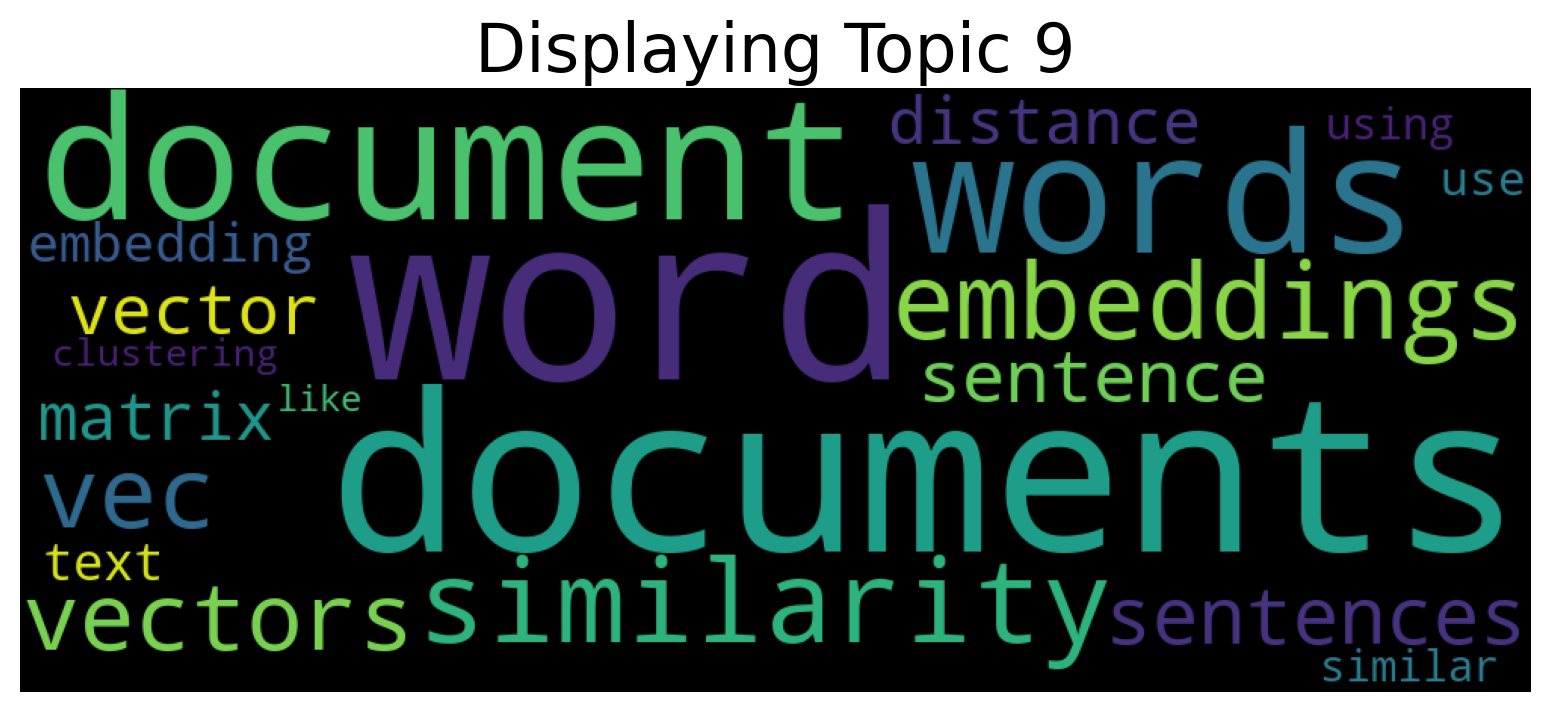

In [ ]:
models.get_wordcloud(topic_id = 9, n_words = 20)

In [ ]:
import pandas as pd

## get the most 3 probable topics for each post
top3perdocument = np.argsort(-topics_predictions)[:, :3]
top3perdocument = pd.DataFrame({'Top 1': top3perdocument[: , 0],'Top 2': top3perdocument[: , 1],'Top 3': top3perdocument[: , 2]})
top3perdocument

In [ ]:
count_top3_topics = top3perdocument.apply(pd.Series.value_counts)
count_top3_topics

In [ ]:
## get the most probable topics per document
topics = [np.argmax(x) for x in topics_predictions]

In [ ]:
from collections import Counter
a = Counter(topics)
df = pd.DataFrame.from_dict(a, orient = 'index').reset_index()
df = df.rename(columns = {'index' : 'topic', 0 :'count'})

## allign topic words to dataframes
df['words'] = df.topic.apply(lambda x: ' ,'.join(map(str, models.get_topic_lists(40)[x])))
pd.set_option('display.max_colwidth', None)
df.sort_values(by=['count'])